# Discovering the number of events

We usually do not have precise enough information to decide a priori on a number of events that an HMP model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data).

> [!NOTE]
> See also the preprint for a re-analysis of the whole dataset : [Trial-by-trial detection of cognitive events in neural time-series](https://www.biorxiv.org/content/10.1101/2024.02.13.580102v1)




In this experiment, participants performed a random-dot motion task. They were asked to indicate the direction of motion of a cloud of moving dots. While a proportion of the dots moved in a target direction, the remainder moved randomly and makes the direction discrimination more difficult. Difficulty of the task was calibrated per subject. Prior to each trial, participants received a cue that indicated whether they should respond as quickly as possible or whether they should focus on giving an accurate response: the 'speed' and 'accuracy' conditions. In this tutorial we will ignore the difference between these conditions, but in the next tutorial we will look at how we can take conditions into account in the HMP analysis.

In this tutorial we will look at leave-one-out-cross validation (LOOCV) to test for the number of events in the data.

## Data preparation

First, we load the required packages and load the data.

In [1]:
import os
import numpy as np
import xarray as xr
import hmp
from mne.io import read_info
import multiprocessing as mp

cpus = 5
#When using multiple CPUs explicitely setting the context of the multiprocessing is needed
#The following line works in most environment
mp.set_start_method("spawn")
#If multiprocessing errors/warning still present comment previous line and uncomment this one
# mp.set_start_method("fork")

# EEG data
epoch_data = xr.load_dataset(os.path.join('sample_data/sample_data.nc'))

# channel information
info = read_info(os.path.join('sample_data/eeg/processed_0022_epo.fif'), verbose=False)

print(epoch_data)
info

<xarray.Dataset> Size: 38MB
Dimensions:      (epochs: 200, channels: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 191 192 193 194 195 196
    stim         (participant, epochs) float64 6kB 2.0 1.0 1.0 ... nan 2.0 1.0
    resp         (participant, epochs) <U10 32kB 'resp_left' ... 'resp_left'
    rt           (participant, epochs) float64 6kB 0.942 1.003 ... 0.392 0.376
    cue          (participant, epochs) <U2 6kB 'SP' 'AC' 'AC' ... '' 'SP' 'SP'
    movement     (participant, epochs) <U10 32kB 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) <U24 77kB 'SP/stim_right/resp_left' .....
  * participant  (participant) <U18 288B 'processed_0025_epo' ... 'processed_...
Data variables:
    data         (participant, epochs, channels, samples) float64 38MB 2.891 ...

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,1.00 Hz
Lowpass,35.00 Hz


At this point we have the epoched EEG data with 30 channels, which we need to transform to PC space. When transforming the data, a prompt requests how many PCs we want to keep. The best is to maximise the number of components kept so that we don't loose PCs with useful information. However, the more PCs we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PCs that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method).

The HMP `transform_data` function will show you the two graphs below, and asks you how many PCs you would like to retain:

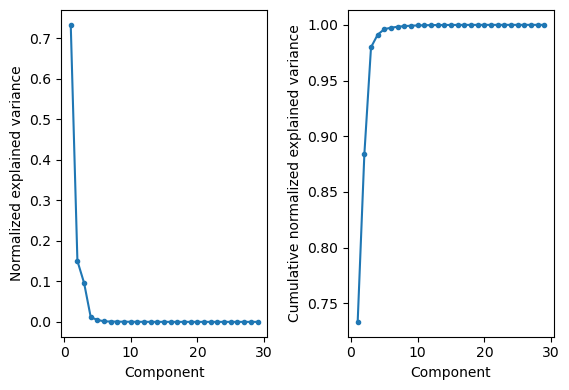

How many PCs (95 and 99% explained variance at component n3 and n4; components till n4 explain at least 1%)? 4


In [2]:
hmp_data = hmp.utils.transform_data(epoch_data)

In this case we see that 99% explained variance is achieved with 4 PCs, and that this is coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with more PCs, but the elbow might occur before).

In [3]:
print(hmp_data)

<xarray.DataArray (component: 4, all_samples: 52641)> Size: 2MB
array([[-0.05894718,  0.84119181,  0.91816998, ...,  2.11262269,
         1.52957905,  0.53073682],
       [-0.77386943, -0.43971168, -0.4426232 , ...,  1.85039281,
         0.74365122,  0.46665992],
       [ 1.15869995,  0.97934906,  1.01218395, ..., -0.07977954,
        -0.43680651, -0.99577141],
       [ 0.50365631, -0.27541355, -0.17288311, ...,  1.12119844,
         0.64089145,  0.13504436]])
Coordinates:
    stim         (all_samples) float64 421kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    resp         (all_samples) <U10 2MB 'resp_left' 'resp_left' ... 'resp_left'
    rt           (all_samples) float64 421kB 0.942 0.942 0.942 ... 0.376 0.376
    cue          (all_samples) <U2 421kB 'SP' 'SP' 'SP' 'SP' ... 'SP' 'SP' 'SP'
    movement     (all_samples) <U10 2MB 'stim_right' ... 'stim_left'
    trigger      (all_samples) <U24 5MB 'SP/stim_right/resp_left' ... 'SP/sti...
  * component    (component) int64 32B 0 1 2 3
  * a

The data is now arranged as 4 PCs x 52641 samples: all trials of all participants were concatenated for the remainder of the analysis.

Finally, we need to initialize the model.

In [4]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus)

# Leave-one-out-cross validation (LOOCV)

To start, we use the `fit` method to calculate the 'maximum solution' – it will find all likely events in the data. As introduced in Tutorial 2, the ```fit``` function slides potential events from 0 to mean RT. When an event is found – the Expectation Maximization estimation converges – one event is added to the model and the slide continues. This way we can detect new events while accounting for the previous ones. 

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 1 found around sample 9
Transition event 2 found around sample 26
Transition event 3 found around sample 41
Transition event 4 found around sample 68

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


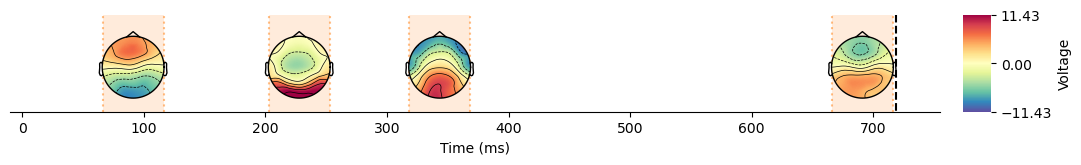

In [5]:
#estimate maximal model using fit
max_model = init.fit()
hmp.visu.plot_topo_timecourse(epoch_data, max_model, info, init, as_time=True)

Here the `fit` method found four events. Next, we use `backward_estimation` – as introduced in the previous tutorial – to generate probable solutions with different numbers of events. We use the 'maximum solution' from the `fit` function as the starting point.

Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events


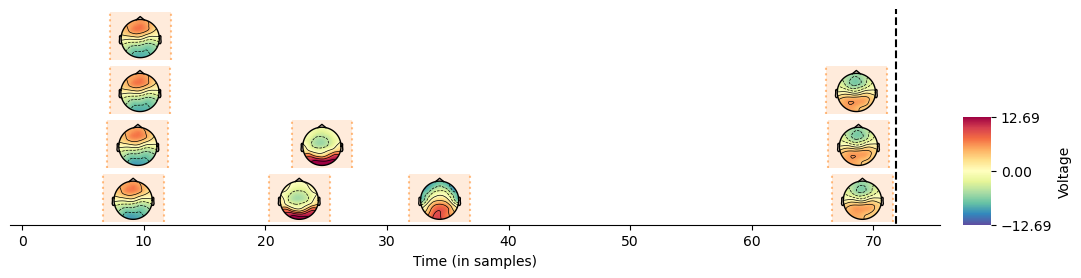

In [6]:
backward_model = init.backward_estimation(max_fit=max_model)
hmp.visu.plot_topo_timecourse(epoch_data, backward_model, info, init)

To determine which of the models really describes the data best, one might be inclined to look at the raw likelihood of the solutions:

Text(0.5, 0, 'N-event model')

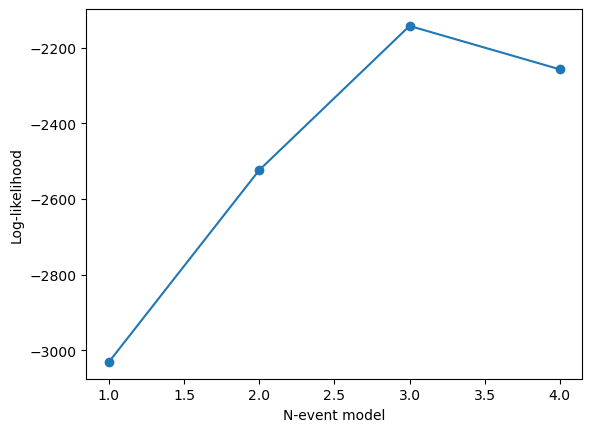

In [7]:
import matplotlib.pyplot as plt 

plt.plot(backward_model.n_events, backward_model.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')

Unfortunately, adding more parameters will almost always improve the fit (except when events start pushing each other away because of the defined minimum duration), here up to 3 events.

Hence we need a way to penalize the likelihood if solutions do not generalize to all participants. One way to do this is to perform leave-one out cross validation (LOOCV). This approach consists of fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters on the other participants. The function ```hmp.loocv.loocv``` does exactly this. If we give it any model as input (including the results of backward estimation), it will fit models with the given model as starting points on _n-1_ participants and estimate the likelihood of the _nth_ participant, and repeat this for all _n_.

Note that LOOCV can be slow when there are many participants, in this case it might be worth it to add multiprocessing through the cpus parameter. However, this increases the memory use, so try to balance CPU use and memory depending on your situation.

In [8]:
loocv_model = hmp.loocv.loocv(init, hmp_data, backward_model)


IMPORTANT:  This loocv procedure is incorrect in the sense that an initial estimate
is used to inform both the fit of the left-out participant and the other participants.
This means that they are not fully independent, unless the initial estimate is
based on the literature or another task. However, it does give a very good initial
idea of the correct loocv procedure and is relatively quick.

To do loocv correctly, use loocv_backward or the general loocv_func,
which calculate the initial estimate for every fold by applying
backward estimation or your own function, respectively.

LOOCV started for 1 model(s)
	LOOCV for backward estimation models with [4 3 2 1] event(s)
	  Estimating backward estimation model with 4 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 3 event(s)

We can then plot the result from the LOOCV procedure, with the likelihood per participant in the graph on the left, and the changes in likelihood on the right.

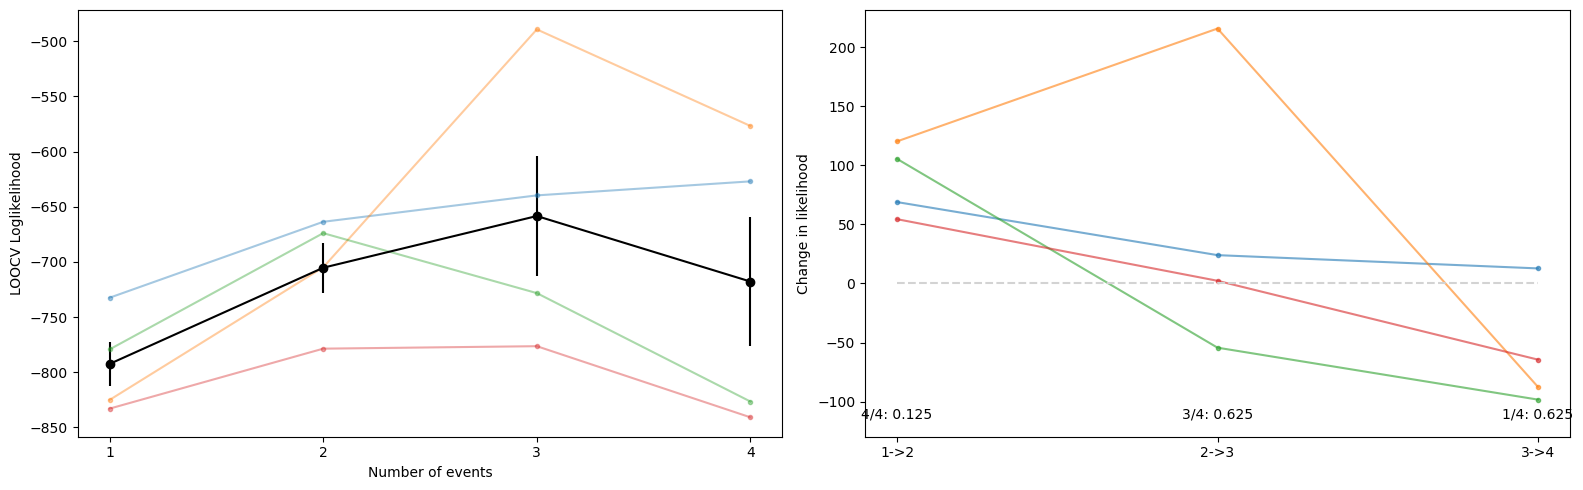

In [9]:
hmp.visu.plot_loocv(loocv_model, pvals=True, test='sign', indiv=True, mean=True) #Colored shaded lines represent individuals

The figure on the right contains p-values for sign tests evaluating whether the fit improved for a significant number of subjects, but this cannot be significant with 4 participants. With 4 participants the results are obviously not to be taken too seriously. In that case we'll just select three events.

In normal-sized datasets, one can use the sign-test to see how many events generalize across subjects, and that is also typically done (see also [this paper](https://link.springer.com/article/10.1007/s42113-021-00105-2) for further discussion on this topic).

We can now plot the final model:

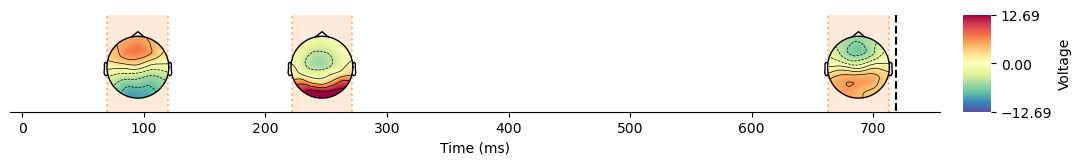

In [10]:
final_model = backward_model.sel(n_events=3)
hmp.visu.plot_topo_timecourse(epoch_data, final_model, info, init, as_time=True)

You might have noticed that the `loocv` method printed a warning saying that it is incorrect. The reason for this is that the input model is used to inform the models fitted to _n-1_ participants, while this input model was based on all participants. Therefore, the calculated loglikelihood of the _nth_ subject is not completely independent of the other participants. We do provide this function, because it a) provides a quick way to estimating rough LOOCV values and b) can be used if you have independent starting points, perhaps from the literature or other studies in your lab.

Of course, we also included a correct method. `loocv_func` will apply a given function (for example, backward estimation) to _n-1_ participants, and then calculate the fit. Unforunately, as in this case we don't have useful starting points it will take much longer to calculate. As we typically do this for backward estimation, we also provide a function specifically for this: `loocv_backward`. In the next tutorial we will illustrate how it can be used in a more complex situation (backward estimation followed by condition-specific models). Both `loocv_func` and `loocv_backward` return a list: the first item contains the loglikelihoods, the second item the fitted models to _n-1_ participants that can be used to construct the final model.

Executing the code below will take quite some time!

Calculating estimates with func <function backward_func at 0x7b3565584220> and args [4, 0, 1, 'random', 0.0001, 1000.0].
	Estimating model for all participants except processed_0025_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events
	Estimating model for all participants except processed_0023_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events
	Estimating model for all participants except processed_0024_epo
Estimating all solutions for maximal number of events (4) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all so

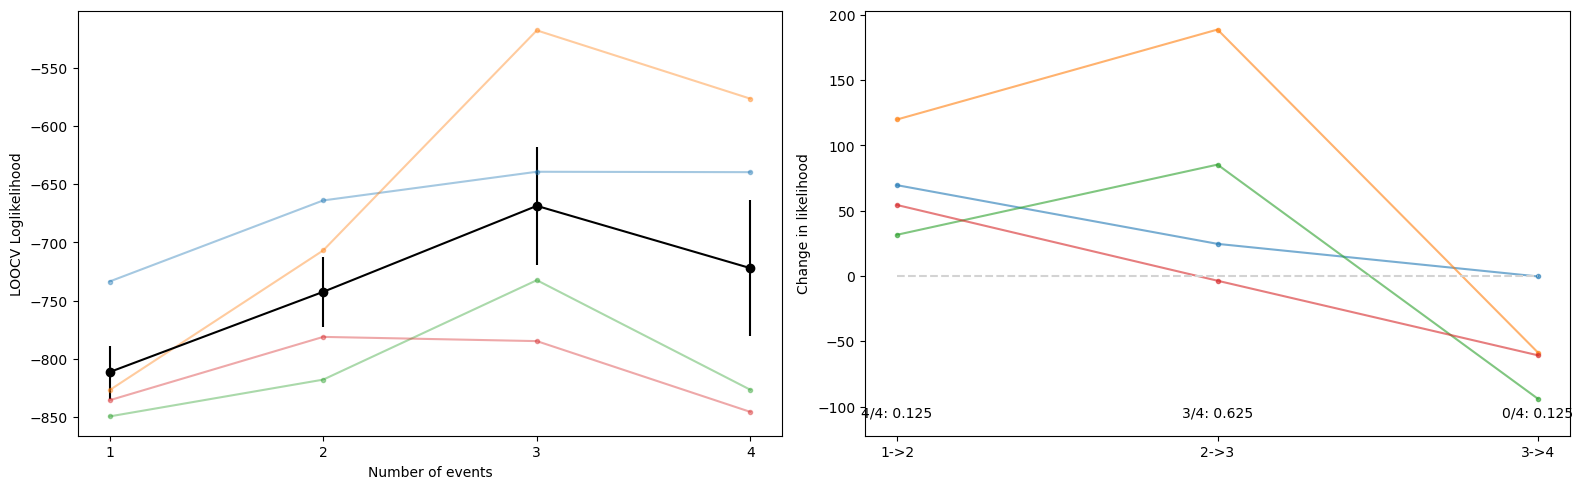

In [11]:
correct_loocv_model = hmp.loocv.loocv_backward(init, hmp_data, max_events=4)
hmp.visu.plot_loocv(correct_loocv_model[0], pvals=True, test='sign', indiv=True, mean=True)

Not only are these results correct, but they are also smoother than the ones before.

Estimating 3 events model
parameters estimated for 3 events model


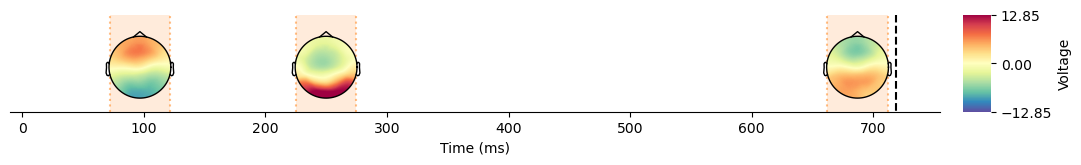

In [12]:
models = correct_loocv_model[1]

#get average mags and params
mags = models[0].sel(n_events=3).magnitudes.dropna('event')
params = models[0].sel(n_events=3).parameters.dropna('stage')
for pp in range(1,len(np.unique(models[0].participant.values))):
    mags += models[pp].sel(n_events=3).magnitudes.dropna('event')
    params += models[pp].sel(n_events=3).parameters.dropna('stage')
mags = mags / len(np.unique(models[0].participant.values))
params = params / len(np.unique(models[0].participant.values))

#fit final model
correct_final_model = init.fit_single(3,magnitudes=mags,parameters=params)
hmp.visu.plot_topo_timecourse(epoch_data, correct_final_model, info, init, as_time=True, contours=0)

... which is, as expected, very similar to the one above.